In [1]:
import os
# import cv2
import numpy as np
import torch
from PIL import Image
from os import mkdir,path
from shutil import rmtree

from torchvision import models, transforms

prepare files

In [2]:
if path.isdir('test'):
    rmtree('test')
if path.isdir('results'):
    rmtree('results')

In [3]:
mkdir('test')
mkdir('results')

In [4]:
big_picture = Image.open('big.png').convert('RGB')
small_picture = Image.open('small.png').convert('RGB')
# big_picture = Image.open('sotabig.JPG').convert('RGB')
# small_picture = Image.open('sotasmall.JPG').convert('RGB')

In [5]:
if path.isdir('results'):
    rmtree('results')

mkdir('results')

load the model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True).to(device)

model = torch.nn.Sequential(*(list(model.children())[:-2])).to(device)

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

put the big picture into the model

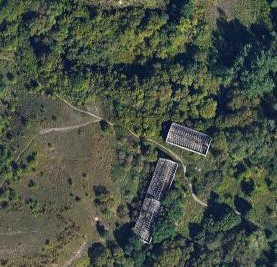

In [8]:
big_picture

In [9]:
big_picture.size

(277, 267)

In [10]:
big_picture_torch = data_transforms(big_picture).to(device)

In [11]:
big_picture_torch.size()

torch.Size([3, 267, 277])

In [12]:
resnet_out_big = model(big_picture_torch.unsqueeze(0))

In [13]:
resnet_out_big.size()

torch.Size([1, 2048, 9, 9])

In [14]:
resnet_out_big = resnet_out_big.squeeze()

In [15]:
resnet_out_big.size()

torch.Size([2048, 9, 9])

put small pictures into the model

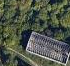

In [16]:
small_picture

In [17]:
small_picture.size

(70, 66)

In [18]:
small_pictures_rotated_torch = []
for rotate_angle in range(0, 360, 10):
    small_picture_rotated = small_picture.rotate(rotate_angle)
    small_pictures_rotated_torch.append(data_transforms(small_picture_rotated))

In [19]:
small_pictures_batch = torch.stack(small_pictures_rotated_torch).to(device)

In [20]:
small_pictures_batch.size()

torch.Size([36, 3, 66, 70])

In [21]:
resnet_outs_small = model(small_pictures_batch)

In [22]:
resnet_outs_small.size()

torch.Size([36, 2048, 3, 3])

compare model outputs for big and small pictures

In [23]:
h_big, w_big = resnet_out_big.size()[1:]
h_big, w_big

(9, 9)

In [24]:
min_m = 10000
min_angle = None
min_h_shift = None
min_w_shift = None

for i, resnet_out_small in enumerate(resnet_outs_small):
    h_small, w_small = resnet_out_small.size()[1:]
    for h_shift in range(h_big - h_small):
        for w_shift in range(w_big - w_small):
            resnet_out_big_cut = resnet_out_big[:, h_shift:h_shift+h_small, w_shift:w_shift+w_small]
            similarity_measure = torch.mean((resnet_out_big_cut - resnet_out_small) ** 2).item()
            if similarity_measure < min_m:
                min_m = similarity_measure
                min_angle = 10*i
                min_h_shift = h_shift
                min_w_shift = w_shift
                print(min_m, min_angle, min_h_shift, min_w_shift)

0.6414974331855774 0 0 0
0.6061657667160034 0 1 0
0.5809004306793213 0 1 1
0.5753558874130249 150 0 3
0.5659161806106567 150 0 4
0.5472737550735474 150 0 5
0.5452029705047607 150 1 1
0.5339773893356323 210 0 2
0.5273394584655762 210 1 0
0.4918915331363678 210 1 1
